In [40]:
import numpy as np
import matplotlib.pyplot as plt
import sys

sys.path.append("../../../XRaySimulation2")

from XRaySimulation import util
import scipy.signal as sps


# Explanation
### Step 1: Calculate the illumination volume of the two pump pulse
The illumination volume is contains in a region of 
20 um x 40 um x 100 um  (x, y, z)
Therefore, I can create a box with resolution of 1um along each axis
Then, I will calculate if this pixel is illuminated.
Then, I will calculate along the z axis, how many TG periods are in the illumination volume
Then, I'll calculate the mean TG period number

### Step 2: Calculate the coherent volume of the probe pulse
I have the calculation process in paper format.

In [41]:
def add_weight_cylinder(start, direction, fwhm_xy, space, attenuation_length_um, surface_point, surface_normal,
                        beam_attenaution=False):
    # Get the distance
    l_pixel = (space - surface_point[np.newaxis, np.newaxis, np.newaxis, :])
    l_pixel = np.dot(l_pixel, surface_normal)
    l_pixel /= np.dot(direction, surface_normal)

    # Get a mask such that we only keep the pixel inside the surface
    sample_mask = (l_pixel >= 0)

    # Get a mask that only consider space inside the cylinder
    displacement = (space - start[np.newaxis, np.newaxis, np.newaxis, :])
    deviation = displacement - np.multiply(np.dot(displacement, direction)[:, :, :, np.newaxis],
                                           direction[np.newaxis, np.newaxis, np.newaxis, :])
    displacement_x = deviation[:, :, :, 0]
    displacement_yz = np.sqrt(deviation[:, :, :, 1] ** 2 + deviation[:, :, :, 2] ** 2)

    # Check if the pixel is within the volume of illumination
    x_ray_mask = (displacement_x ** 2 / fwhm_xy[0] ** 2 + displacement_yz ** 2 / fwhm_xy[1] ** 2 - 1 <= 0)
    total_mask = np.multiply(sample_mask, x_ray_mask)

    # Add the weight according to the attenuation coefficient
    weight = np.zeros_like(displacement_x, dtype=np.float64)
    weight[total_mask] = np.exp(-l_pixel[total_mask] / attenuation_length_um)

    if beam_attenaution:
        print("Get get the weight assuming a Gaussian X-ray profile")
        sigma_x = util.fwhm_to_sigma(fwhm=fwhm_xy[0])
        sigma_y = util.fwhm_to_sigma(fwhm=fwhm_xy[1])

        weight *= np.exp(- displacement_x ** 2 / sigma_x ** 2 / 2) / np.sqrt(np.pi * 2) / sigma_x
        weight *= np.exp(- displacement_yz ** 2 / sigma_y ** 2 / 2) / np.sqrt(np.pi * 2) / sigma_y

    else:
        print("Get get the weight assuming a flat X-ray profile")

    return weight

In [42]:
#kin = np.array([-1398.73758358, -19381.33420562, 45704.44855449])
kin = np.array([-0.11689482, -1.97294018, 4.55617549]) * 1e4
kin_direction = kin / np.linalg.norm(kin)

tilt_angle = np.deg2rad(11.5)
surface_normal = np.array([np.cos(tilt_angle), 0, -np.sin(tilt_angle)])

beam_size_x = 5.  # um
beam_size_y = 10.  # um
coh_length = 10 * util.c  # um

# Get the sigma
beam_sigma_x = util.intensity_fwhm_to_field_sigma(fwhm=beam_size_x)
beam_sigma_y = util.intensity_fwhm_to_field_sigma(fwhm=beam_size_y)
beam_sigma_z = util.intensity_fwhm_to_field_sigma(fwhm=coh_length)

nx = 256
ny = 64
nz = 256

dx = 11.8 / 100
dy = 3. / 2
dz = 0.5 / 2

volume = np.zeros((nx, ny, nz, 3))
x_coor = np.linspace(-nx * dx / 2, nx * dx / 2, num=nx)
y_coor = np.linspace(-ny * dy / 2, ny * dy / 2, num=ny)
z_coor = np.linspace(-nz * dz / 2, nz * dz / 2, num=nz)

volume[:, :, :, 0] = x_coor[:, np.newaxis, np.newaxis]
volume[:, :, :, 1] = y_coor[np.newaxis, :, np.newaxis]
volume[:, :, :, 2] = z_coor[np.newaxis, np.newaxis, :]

In [43]:
# Get the total weight
weight_pulse1 = add_weight_cylinder(start=np.zeros(3),
                                    direction=np.array([np.sin(np.deg2rad(0.2)), 0, np.cos(np.deg2rad(0.2))]),
                                    fwhm_xy=[beam_size_x, beam_size_y],
                                    space=volume,
                                    attenuation_length_um=31.534,
                                    surface_point=np.zeros(3),
                                    surface_normal=np.copy(surface_normal),
                                    beam_attenaution=True)
weight_pulse2 = add_weight_cylinder(start=np.zeros(3),
                                    direction=np.array([-np.sin(np.deg2rad(0.2)), 0, np.cos(np.deg2rad(0.2))]),
                                    fwhm_xy=[beam_size_x, beam_size_y],
                                    space=volume,
                                    attenuation_length_um=31.534,
                                    surface_point=np.zeros(3),
                                    surface_normal=np.copy(surface_normal),
                                    beam_attenaution=True)
weight_pulse3 = add_weight_cylinder(start=np.zeros(3),
                                    direction=kin_direction,
                                    fwhm_xy=[beam_size_x, beam_size_y],
                                    space=volume,
                                    attenuation_length_um=31.534,
                                    surface_point=np.array([0., 0., 0.]),
                                    surface_normal=np.copy(surface_normal),
                                    beam_attenaution=True)
pump_weight = weight_pulse1 + weight_pulse2
probe_weight = weight_pulse3

total_weight = probe_weight + pump_weight

Get get the weight assuming a Gaussian X-ray profile
Get get the weight assuming a Gaussian X-ray profile
Get get the weight assuming a Gaussian X-ray profile


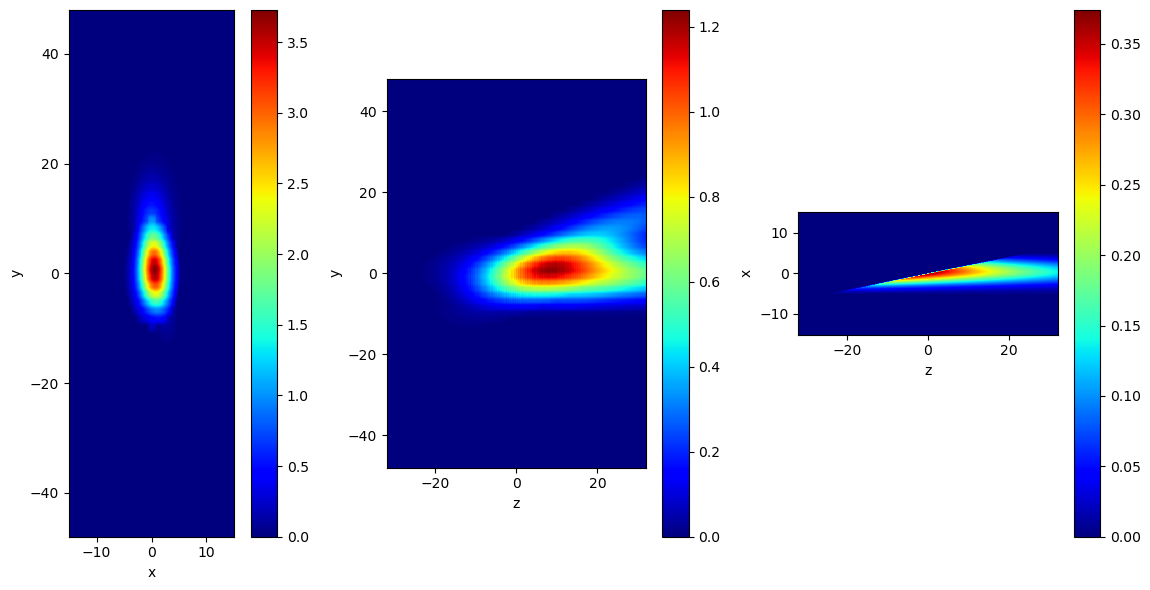

In [44]:
weight_xy = np.sum(total_weight, axis=-1)
weight_xz = np.sum(total_weight, axis=1)
weight_yz = np.sum(total_weight, axis=0)

fig, axes = plt.subplots(ncols=3, nrows=1)
fig.set_figheight(6)
fig.set_figwidth(12)
im1 = axes[0].imshow(weight_xy.T[:, ::-1], extent=[-nx * dx / 2, nx * dx / 2, -ny * dy / 2, ny * dy / 2, ], cmap='jet')
fig.colorbar(im1, ax=axes[0])
axes[0].set_xlabel("x")
axes[0].set_ylabel("y")

im2 = axes[1].imshow(weight_yz, extent=[-nz * dz / 2, nz * dz / 2, -ny * dy / 2, ny * dy / 2, ], cmap='jet')
fig.colorbar(im2, ax=axes[1])
axes[1].set_xlabel("z")
axes[1].set_ylabel("y")

im3 = axes[2].imshow(weight_xz[::-1, ], extent=[-nz * dz / 2, nz * dz / 2, -nx * dx / 2, nx * dx / 2], cmap='jet')
fig.colorbar(im3, ax=axes[2])
axes[2].set_xlabel("z")
axes[2].set_ylabel("x")

plt.tight_layout()
plt.show()

In [45]:
volume_illu = np.multiply(weight_pulse1, weight_pulse2)  # This is the total illumination volume of the two pump pulses.
# Get the scattering volume
### Then we can use the weighted center of this scattering volume to calculate the path length difference
scatter_volume = np.multiply(volume_illu, weight_pulse3)

# Get the center from which to calculate the path length difference
weight_x = np.sum(scatter_volume, axis=(1, 2))
weight_y = np.sum(scatter_volume, axis=(0, 2))
weight_z = np.sum(scatter_volume, axis=(0, 1))

weight_x /= np.sum(weight_x)
weight_y /= np.sum(weight_y)
weight_z /= np.sum(weight_z)

x_center = np.sum(np.multiply(weight_x, x_coor))
y_center = np.sum(np.multiply(weight_y, y_coor))
z_center = np.sum(np.multiply(weight_z, z_coor))

ref_point = np.array([x_center, y_center, z_center])

print("The center of the scattering volume is at x {}, y {}, z {} ".format(x_center, y_center, z_center))

The center of the scattering volume is at x -0.28248828313137336, y -0.6885927318308224, z 5.181378132112904 


In [77]:
# Calculate the source position of the X-ray probe pulse to calculate the path length difference
source_point = -kin_direction * 1e6 + ref_point
print("Assume that the probe pulse starts from location:", source_point)

# Calculate the pixel position
g_vec = np.array([3.11361484, 3.2118638, -0.83751243])
g_dir = g_vec / np.linalg.norm(g_vec)

kout = np.array([3.04983703, 1.23892362, 3.71866306])
kout_dir = kout / np.linalg.norm(kout)

# Get the relative position between the pixel and the reference point
pixel_position = ref_point + kout_dir / kout_dir[2] * 125e3  
print(pixel_position)

Assume that the probe pulse starts from location: [  23536.96389754  397258.82317308 -917399.2432592 ]
[102517.64468041  41644.77645782 125005.18137813]


In [84]:
# For each point in the scattering volume, calculate the path length from the source point to the pixel
volume_path = np.linalg.norm(volume - source_point[np.newaxis, np.newaxis, np.newaxis, :], axis=-1)
#volume_path = np.dot(volume - source_point[np.newaxis, np.newaxis, np.newaxis, :], kin_direction)
volume_path += np.linalg.norm(volume - pixel_position[np.newaxis, np.newaxis, np.newaxis, :], axis=-1)
volume_path -= (1e6 + 125e3 / kout_dir[2])
#volume_path -= 125e3 / kout_dir[2]
volume_path = np.abs(volume_path)

volume_coh = (volume_path <= coh_length / 2.).astype(np.float64)

In [85]:
np.min(volume_path)

1.048017293214798e-05

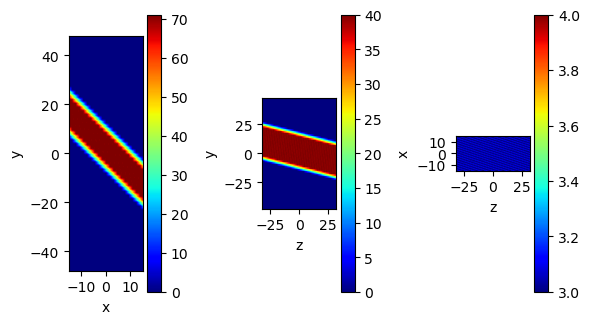

In [86]:
weight_xy = np.sum(volume_coh, axis=-1)
weight_xz = np.sum(volume_coh, axis=1)
weight_yz = np.sum(volume_coh, axis=0)

fig, axes = plt.subplots(ncols=3, nrows=1)
fig.set_figheight(12)
fig.set_figwidth(6)
im1 = axes[0].imshow(weight_xy.T[:, ::-1], extent=[-nx * dx / 2, nx * dx / 2, -ny * dy / 2, ny * dy / 2, ], cmap='jet')
fig.colorbar(im1, ax=axes[0])
axes[0].set_xlabel("x")
axes[0].set_ylabel("y")

im2 = axes[1].imshow(weight_yz, extent=[-nz * dz / 2, nz * dz / 2, -ny * dy / 2, ny * dy / 2, ], cmap='jet')
fig.colorbar(im2, ax=axes[1])
axes[1].set_xlabel("z")
axes[1].set_ylabel("y")

im3 = axes[2].imshow(weight_xz[::-1, ], extent=[-nz * dz / 2, nz * dz / 2, -nx * dx / 2, nx * dx / 2], cmap='jet')
fig.colorbar(im3, ax=axes[2])
axes[2].set_xlabel("z")
axes[2].set_ylabel("x")

plt.tight_layout()
plt.show()

In [87]:
## Get the volume assuming full coherence
volume_fft = np.square(np.abs(np.fft.fftshift(np.fft.fftn(scatter_volume))))

kx = np.fft.fftshift(np.fft.fftfreq(n=nx, d=dx)) * np.pi * 2  #/ 1e4
ky = np.fft.fftshift(np.fft.fftfreq(n=ny, d=dy)) * np.pi * 2  #/ 1e4
kz = np.fft.fftshift(np.fft.fftfreq(n=nz, d=dz)) * np.pi * 2  #/ 1e4

volume_coh_fft = np.square(np.abs(np.fft.fftshift(np.fft.fftn(volume_coh))))

### Get the total volume
volume_total = sps.fftconvolve(volume_fft, volume_coh_fft, mode='same')

### Get the projection
proj_xz = np.sum(volume_total, axis=1)

In [88]:
# Get the wave-vectors
angle_num = 1000
angle_list = np.linspace(start=-np.deg2rad(0.05), stop=np.deg2rad(0.05), num=angle_num)

fit_x = np.array([6.40342603e-01, 5.06962809e-09]) * 1e4
fit_y = np.array([1.99944147e-01, -4.08478486e-07]) * 1e4
fit_z = np.array([3.14738445e+00, 2.49180183e-08]) * 1e4

fit_qx = angle_list * fit_x[0] + fit_x[1]
fit_qy = angle_list * fit_y[0] + fit_y[1]
fit_qz = angle_list * fit_z[0] + fit_z[1]

q_list = np.zeros((angle_num, 3))
q_list[:, 0] = fit_qx
q_list[:, 1] = fit_qy
q_list[:, 2] = fit_qz

from scipy.interpolate import RegularGridInterpolator

interp = RegularGridInterpolator((kx, ky, kz), volume_total, bounds_error=False, fill_value=None)
rock = interp(q_list)


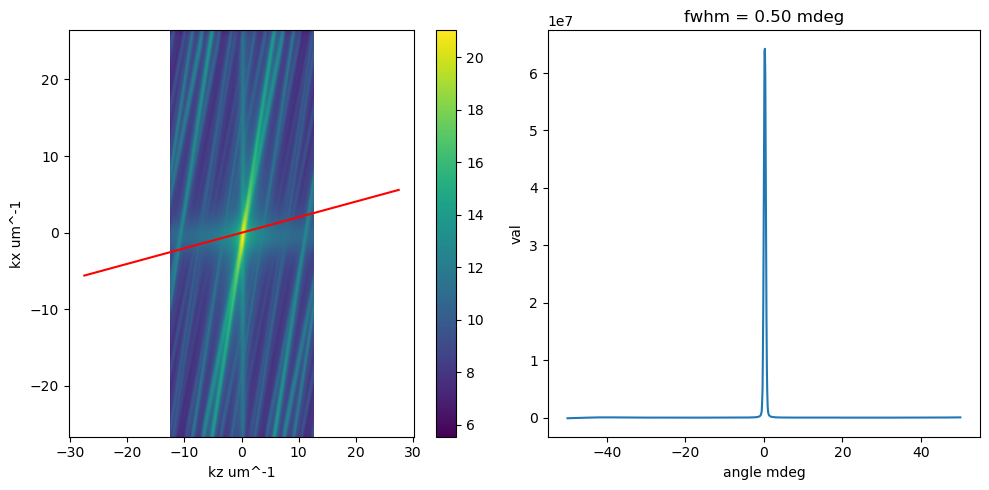

In [89]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))

#img1 = axes[0].imshow(np.log(proj_xz), vmax=-16, vmin=-25, extent=[kz[0], kz[-1], kx[0], kx[-1]], aspect='auto')
img1 = axes[0].imshow(np.log(proj_xz), extent=[kz[0], kz[-1], kx[0], kx[-1]], aspect='auto')
fig.colorbar(img1, ax=axes[0])
axes[0].plot(fit_qz, fit_qx, c='r')
axes[0].set_xlabel("kz um^-1")
axes[0].set_ylabel("kx um^-1")

axes[1].plot(np.rad2deg(angle_list) * 1e3, rock)
axes[1].set_xlabel("angle mdeg")
axes[1].set_ylabel("val")
fwhm = util.get_fwhm(coordinate=np.rad2deg(angle_list) * 1e3, curve_values=rock)
axes[1].set_title("fwhm = {:.2f} mdeg".format(fwhm))

plt.tight_layout()
plt.show()